In [55]:
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import numpy as np

In [56]:
data_dir = '/home/jing/Phd_project/project_UCD_blca/blca_DATA/blca_DATA_GSE135337/'
os.chdir(data_dir)

In [3]:
names_list = ["GSM4006644_BC1", "GSM4006647_BC4" ,"GSM4006648_BC5", "GSM4751267_BC6" ,"GSM4751268_BC7"]


GSM4006644_BC1


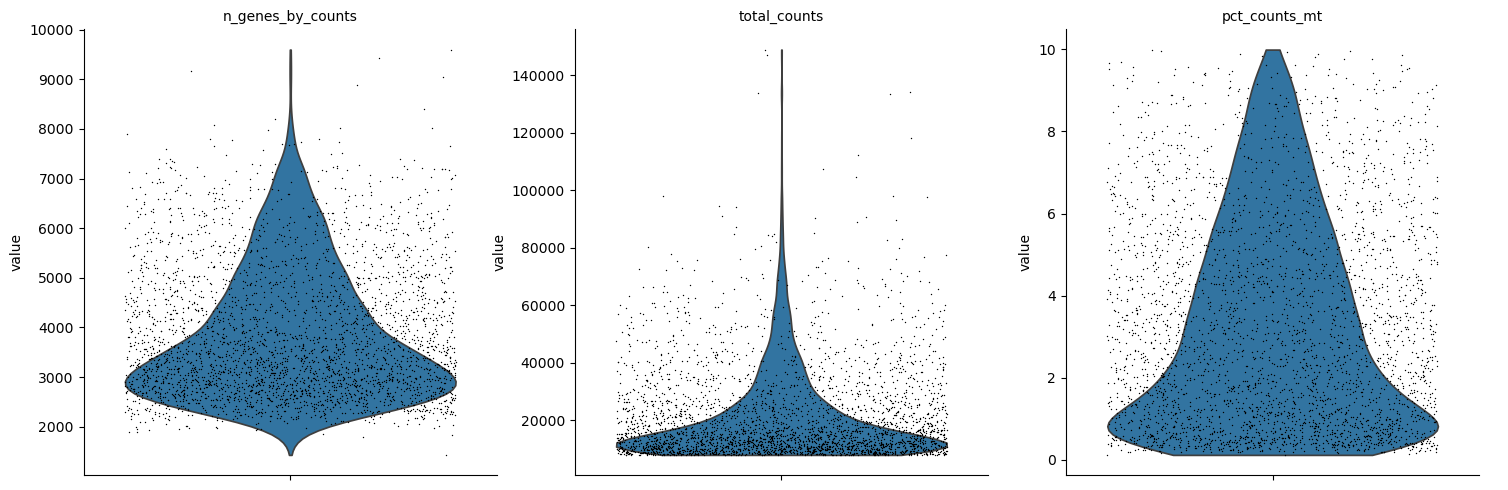

/tmp/ipykernel_2433055/3899688235.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006647_BC4


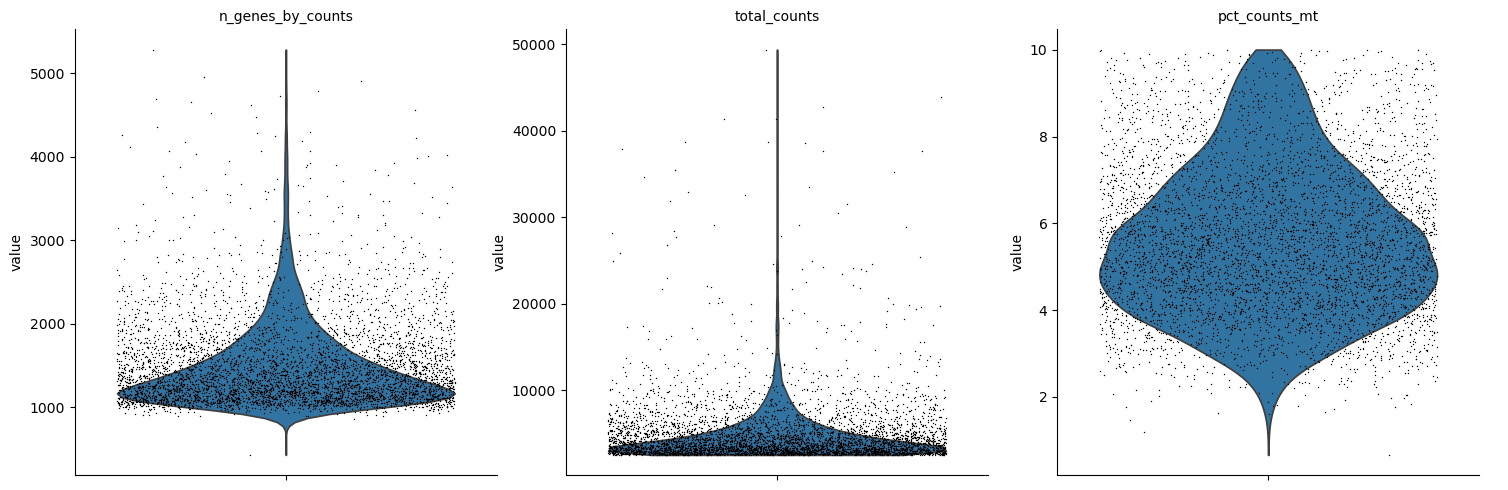

/tmp/ipykernel_2433055/3899688235.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006648_BC5


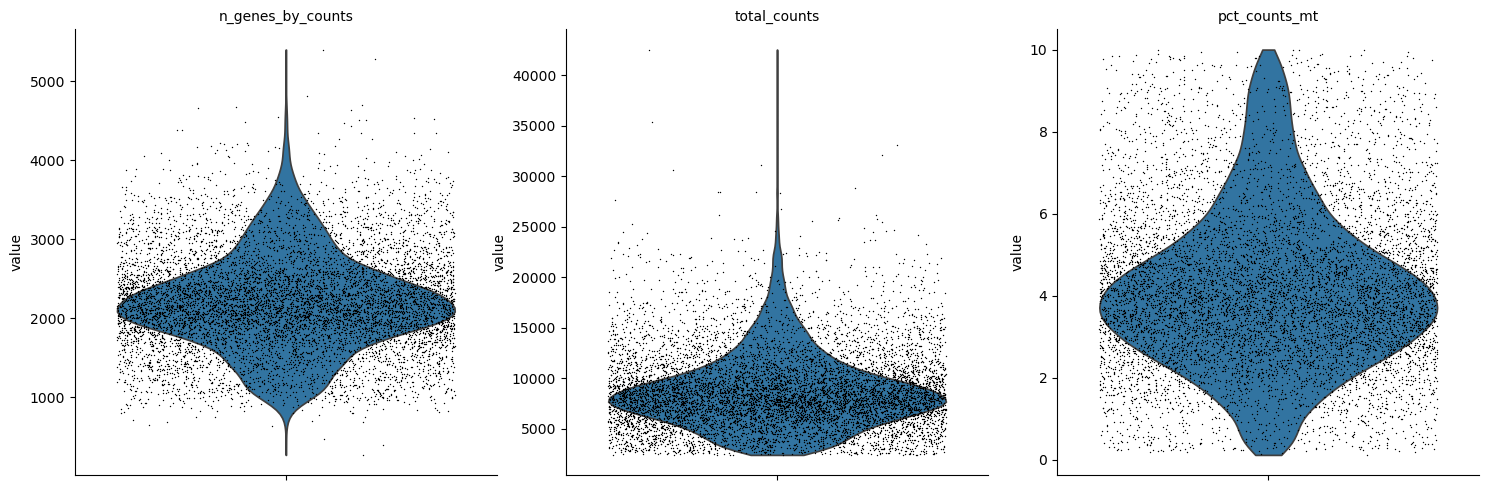

/tmp/ipykernel_2433055/3899688235.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751267_BC6


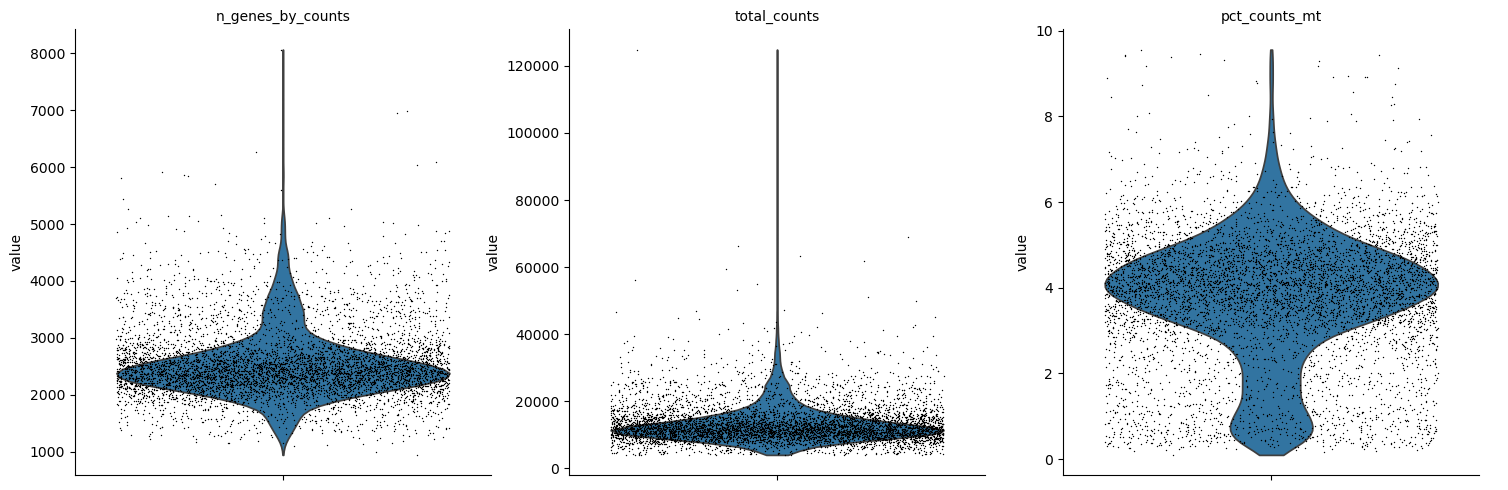

/tmp/ipykernel_2433055/3899688235.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751268_BC7


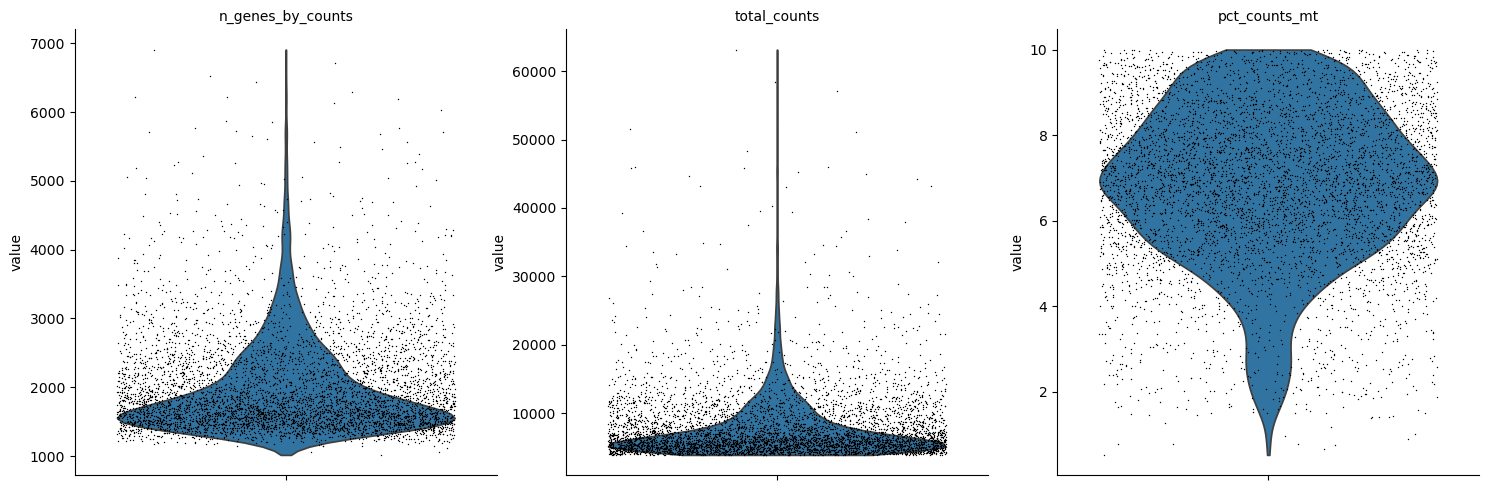

/tmp/ipykernel_2433055/3899688235.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


In [57]:
adata_list = []

# Loop over each sample and read in the AnnData object
for name in names_list:
    file_path = f"{name}_gene_cell_exprs_table.txt.gz"
    df = pd.read_csv(file_path, sep='\t')
    df.index = df.iloc[:, 0]
    gene_symbols = df.iloc[:,:2]

    # Drop the first two columns (Ensembl ID and gene name)
    df = df.iloc[:, 2:]
    # Transpose so that cells are rows and genes are columns
    df = df.T

    adata = ad.AnnData(df)

    adata.obs['CellID']= df.index
    adata.var[['Ensemble_ID','Gene']]= gene_symbols
    adata.var.index= adata.var['Gene']
    adata.var_names_make_unique() 
    adata.var['mt'] =adata.var_names.str.startswith('MT-')

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    print(name)
    sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)
    
    adata= adata[adata.obs.n_genes_by_counts <6001, :]
    #adata= adata[adata.obs.pct_counts_mt< 5, :].copy()

    adata.obs['source'] = name
    adata.layers["counts"] = adata.X.copy()    

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata  # keep full dimension safe
    adata_list.append(adata)

In [58]:
batch_names = [adata.obs['source'].iloc[0] for adata in adata_list]
adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)       

/tmp/ipykernel_2433055/1630503105.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)


In [59]:
immune_remove = pd.read_pickle('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/immune_cells_obs.pkl')

In [7]:
adata_non_immune = adata[~adata.obs.index.isin(immune_remove.index),]

In [8]:
adata_non_immune

View of AnnData object with n_obs × n_vars = 27864 × 13656
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM4751268_BC7', 'Gene-GSM4751268_BC7', '

In [9]:
adata_non_immune.raw = adata_non_immune  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata_non_immune,
    flavor="seurat_v3",
    n_top_genes=2500,
    layer="counts",
    batch_key="source",
    subset=True,
)

In [10]:
adata_non_immune.var

,mt,Ensemble_ID-GSM4006644_BC1,Gene-GSM4006644_BC1,n_cells_by_counts-GSM4006644_BC1,mean_counts-GSM4006644_BC1,pct_dropout_by_counts-GSM4006644_BC1,total_counts-GSM4006644_BC1,Ensemble_ID-GSM4006647_BC4,Gene-GSM4006647_BC4,n_cells_by_counts-GSM4006647_BC4,...,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
Gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,False,ENSG00000000003,TSPAN6,2473,3.086700,23.151025,9933,ENSG00000000003,TSPAN6,1048,...,2339,0.638059,57.649828,3524,True,585.0,0.752082,2.195721,1.075032,1
GCLC,False,ENSG00000001084,GCLC,2693,3.926041,16.314481,12634,ENSG00000001084,GCLC,228,...,1036,0.232301,81.242079,1283,True,1064.5,0.699361,3.074778,1.164049,4
STPG1,False,ENSG00000001460,STPG1,1468,0.857986,54.381603,2761,ENSG00000001460,STPG1,130,...,412,0.100127,92.540286,553,True,1111.0,0.161355,0.307524,1.282538,4
CD99,False,ENSG00000002586,CD99,2584,2.883157,19.701678,9278,ENSG00000002586,CD99,1244,...,1363,0.309614,75.321383,1710,True,684.0,0.728503,1.877584,1.182049,4
HS3ST1,False,ENSG00000002587,HS3ST1,2053,2.312927,36.202610,7443,ENSG00000002587,HS3ST1,396,...,883,0.214738,84.012312,1186,True,591.0,0.816502,2.119469,1.291537,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP11-2C24.9,False,ENSG00000282034,RP11-2C24.9,249,0.085457,92.262275,275,ENSG00000282034,RP11-2C24.9,42,...,145,0.026797,97.374615,148,True,752.0,0.036570,0.039110,0.977658,1
RP11-422P24.12,False,ENSG00000282386,RP11-422P24.12,185,0.062150,94.251088,200,ENSG00000282386,RP11-422P24.12,48,...,36,0.006518,99.348180,36,True,1292.0,0.013781,0.015315,0.989229,1
ADORA3,False,ENSG00000282608,ADORA3,14,0.004972,99.564947,16,ENSG00000282608,ADORA3,12,...,31,0.007605,99.438711,42,True,741.0,0.002333,0.003476,1.267592,3


In [11]:
adata_non_immune.var[adata_non_immune.var['highly_variable']==True].index

Index(['TSPAN6', 'GCLC', 'STPG1', 'CD99', 'HS3ST1', 'TMEM176A', 'CFLAR',
       'TFPI', 'ARF5', 'PLXND1',
       ...
       'CEP83-AS1', 'FO538757.2', 'AC090498.1', 'AC133644.2', 'LINC00921',
       'RP11-2C24.9', 'RP11-422P24.12', 'ADORA3', 'BISPR', 'RP11-297A16.4'],
      dtype='object', name='Gene', length=2500)

In [12]:
import scvi
scvi.model.SCVI.setup_anndata(adata_non_immune, layer="counts", batch_key="source")

In [13]:
model = scvi.model.SCVI(adata_non_immune, n_layers=2, n_latent=30, gene_likelihood="nb")

In [14]:
model.train()

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bo

Training:   0%|          | 0/287 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=287` reached.


In [15]:
SCVI_LATENT_KEY = "X_scVI"
adata_non_immune.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [16]:
sc.pp.neighbors(adata_non_immune, use_rep=SCVI_LATENT_KEY)


In [22]:
sc.tl.leiden(adata_non_immune,resolution=0.5,  random_state=0)

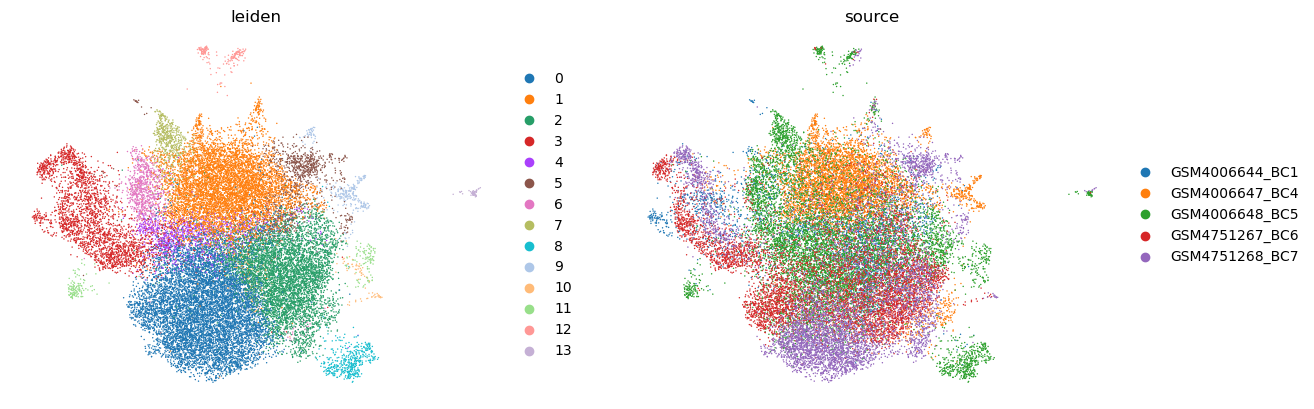

In [24]:
sc.tl.umap(adata_non_immune)#, min_dist=0.5)
sc.pl.umap(
    adata_non_immune,
    color=[ "leiden","source",],
    frameon=False,
    ncols=2
)

In [26]:
###Breakdown of cells counts per cluster
pd.crosstab(adata_non_immune.obs['source'],adata_non_immune.obs['leiden'])

leiden,0,1,2,3,4,5,6,7,8,9,10,11,12,13
source,,,,,,,,,,,,,,
GSM4006644_BC1,306,361,685,558,438,167,163,10,7,9,187,6,2,0
GSM4006647_BC4,21,4490,232,52,1,5,61,4,2,253,0,0,0,0
GSM4006648_BC5,2627,1073,1675,210,599,147,634,509,447,5,48,221,151,44
GSM4751267_BC6,2435,304,1870,1187,72,89,57,0,0,2,17,2,10,1
GSM4751268_BC7,2885,297,950,620,6,586,2,6,1,13,14,0,19,9


In [32]:
adata_non_immune.obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source,_scvi_batch,_scvi_labels,leiden
AAACCTGAGAAGAAGC.1-GSM4006644_BC1,AAACCTGAGAAGAAGC.1,5037,5037,29207,1799,6.159482,GSM4006644_BC1,0,0,0
AAACCTGAGCTACCTA.1-GSM4006644_BC1,AAACCTGAGCTACCTA.1,2769,2769,12115,392,3.235658,GSM4006644_BC1,0,0,3
AAACCTGCACGGCGTT.1-GSM4006644_BC1,AAACCTGCACGGCGTT.1,4385,4385,23784,1480,6.222671,GSM4006644_BC1,0,0,2
AAACCTGCATCTCGCT.1-GSM4006644_BC1,AAACCTGCATCTCGCT.1,4337,4337,17372,248,1.427585,GSM4006644_BC1,0,0,3
AAACCTGTCAGGCCCA.1-GSM4006644_BC1,AAACCTGTCAGGCCCA.1,3700,3700,19616,368,1.876020,GSM4006644_BC1,0,0,3
...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACAGACG.1-GSM4751268_BC7,TTTGTCAGTACAGACG.1,1859,1859,6857,475,6.927228,GSM4751268_BC7,4,0,0
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7,TTTGTCAGTCTAGTCA.1,1420,1420,4543,333,7.329958,GSM4751268_BC7,4,0,0
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7,TTTGTCAGTGGCCCTA.1,4206,4206,21459,1849,8.616431,GSM4751268_BC7,4,0,2
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7,TTTGTCAGTTCTGGTA.1,2581,2581,10731,909,8.470786,GSM4751268_BC7,4,0,1


In [28]:
indices_t2 = pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/index_cluster1T2.csv', header=None)
indices_t2 = indices_t2.values.flatten()

In [30]:
indices_t2

array(['AAACCTGAGTCCAGGA.1-GSM4006647_BC4',
       'AAACCTGCAATTCCTT.1-GSM4006647_BC4',
       'AAACCTGGTGTGACGA.1-GSM4006647_BC4', ...,
       'TTTGTCATCACTGGGC.1-GSM4006647_BC4',
       'TTTGTCATCGCTTGTC.1-GSM4006647_BC4',
       'TTTGTCATCTGTACGA.1-GSM4006647_BC4'], dtype=object)

In [29]:
indices_ta = pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/index_cluster1Ta.csv', header=None)
indices_ta = indices_ta.values.flatten()

In [41]:
adata_non_immune.obs.index

Index(['AAACCTGAGAAGAAGC.1-GSM4006644_BC1',
       'AAACCTGAGCTACCTA.1-GSM4006644_BC1',
       'AAACCTGCACGGCGTT.1-GSM4006644_BC1',
       'AAACCTGCATCTCGCT.1-GSM4006644_BC1',
       'AAACCTGTCAGGCCCA.1-GSM4006644_BC1',
       'AAACCTGTCGGCGGTT.1-GSM4006644_BC1',
       'AAACGGGCAGGTCCAC.1-GSM4006644_BC1',
       'AAACGGGGTCATCGGC.1-GSM4006644_BC1',
       'AAACGGGTCACAATGC.1-GSM4006644_BC1',
       'AAACGGGTCTTGACGA.1-GSM4006644_BC1',
       ...
       'TTTGTCAAGTCAATAG.1-GSM4751268_BC7',
       'TTTGTCACAAAGAATC.1-GSM4751268_BC7',
       'TTTGTCACACAGGTTT.1-GSM4751268_BC7',
       'TTTGTCACAGATTGCT.1-GSM4751268_BC7',
       'TTTGTCACAGGACCCT.1-GSM4751268_BC7',
       'TTTGTCAGTACAGACG.1-GSM4751268_BC7',
       'TTTGTCAGTCTAGTCA.1-GSM4751268_BC7',
       'TTTGTCAGTGGCCCTA.1-GSM4751268_BC7',
       'TTTGTCAGTTCTGGTA.1-GSM4751268_BC7',
       'TTTGTCATCAACCATG.1-GSM4751268_BC7'],
      dtype='object', length=27864)

In [43]:
### DEGs   indices of previous signatures
adata_non_immune.obs['2000_leiden'] = 'None'

for i in indices_t2:
    adata_non_immune.obs.loc[i,'2000_leiden'] ='Cluster1_T2'
for i in indices_ta:
    adata_non_immune.obs.loc[i,'2000_leiden'] ='Cluster1_Ta'

In [44]:
adata_non_immune.obs['2000_leiden'].value_counts()

2000_leiden
None           23339
Cluster1_T2     2872
Cluster1_Ta     1653
Name: count, dtype: int64

In [50]:
cell_type_1 = "Cluster1_T2"
cell_idx1 = adata_non_immune.obs["2000_leiden"] == cell_type_1
print(sum(cell_idx1), "cells of type", cell_type_1)

cell_type_2 = "Cluster1_T2"
cell_idx2 = adata_non_immune.obs["2000_leiden"] != cell_type_2
print(sum(cell_idx2), "cells of type", cell_type_2)

# or equivalently, provide a string of the form "my_celltype_column == 'desired_celltype'"
# cell_idx1 = "cell_type == 'Ciliated_non_amphid_neuron'"
# cell_idx2 = "cell_type == 'Intestine'"

2872 cells of type Cluster1_T2
24992 cells of type Cluster1_T2


In [51]:
de_change = model.differential_expression(idx1=cell_idx1, idx2=cell_idx2)
de_change

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
Gene,,,,,,,,,,,,,,,,,,,
KRTDAP,0.9926,0.0074,4.898846,1.962306e-04,0.000010,0.0,0.25,7.113950,7.412395,2.890081,-6.101099,17.108517,0.551532,0.041253,0.175139,0.018046,2.268787,0.097823,True
KRT14,0.9910,0.0090,4.701489,2.948109e-04,0.000030,0.0,0.25,5.490019,5.763122,2.778075,-5.354922,13.126948,0.574861,0.103113,0.243733,0.056298,2.541044,0.269785,True
MMP12,0.9904,0.0096,4.636345,1.626939e-04,0.000016,0.0,0.25,6.280751,6.661250,2.740819,-7.786514,14.586606,0.245474,0.037972,0.165390,0.023968,1.288232,0.138571,True
S100A8,0.9892,0.0108,4.517349,1.487531e-02,0.000860,0.0,0.25,11.213805,11.092279,5.196137,-3.296721,23.479839,28.701602,2.676416,0.989554,0.160731,143.630692,7.933007,True
FXYD4,0.9892,0.0108,4.517349,5.659346e-07,0.000048,0.0,0.25,-4.885069,-5.089692,2.761749,-15.576115,6.278933,0.000000,0.455466,0.000000,0.109075,0.000000,0.553573,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDUFB4,0.4866,0.5134,-0.053613,5.574128e-04,0.000612,0.0,0.25,-0.098934,-0.072193,0.399680,-1.903354,1.780010,1.033426,3.241117,0.608983,0.897327,5.488662,5.953340,False
EIF3K,0.4830,0.5170,-0.068026,7.638616e-04,0.000644,0.0,0.25,0.309963,0.177320,0.509507,-0.875335,2.767947,1.554318,3.565941,0.756267,0.900128,8.151545,6.516259,False
SERP1,0.4628,0.5372,-0.149075,5.752941e-04,0.000600,0.0,0.25,-0.044568,-0.028369,0.341292,-2.353777,1.053474,1.029944,3.264445,0.614903,0.889165,5.419315,5.831564,False


In [52]:
de_change_uniform = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="uniform",
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_uniform["log10_pscore"] = np.log10(de_change_uniform["proba_not_de"])
de_change_uniform = de_change_uniform.join(adata.var, how="inner")
de_change_uniform.head()

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,n_cells_by_counts-GSM4751267_BC6,mean_counts-GSM4751267_BC6,pct_dropout_by_counts-GSM4751267_BC6,total_counts-GSM4751267_BC6,Ensemble_ID-GSM4751268_BC7,Gene-GSM4751268_BC7,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7
Gene,,,,,,,,,,,,,,,,,,,,,
PIGR,0.9238,0.0762,2.495134,0.000015,0.000017,0.0,0.25,0.917361,1.027778,2.364379,...,159,0.064213,97.421761,396,ENSG00000162896,PIGR,423,0.285352,92.341119,1576
CXCL10,0.9204,0.0796,2.447794,0.000020,0.000021,0.0,0.25,0.386863,0.383181,2.383039,...,17,0.021729,99.724339,134,ENSG00000169245,CXCL10,19,0.051240,99.655984,283
S100A8,0.9178,0.0822,2.412824,0.002929,0.001913,0.0,0.25,0.717893,0.747483,2.348737,...,6,0.001459,99.902708,9,ENSG00000143546,S100A8,22,0.022089,99.601666,122
LCN2,0.9160,0.0840,2.389199,0.000194,0.000223,0.0,0.25,0.699639,0.849044,2.192941,...,594,0.274364,90.368088,1692,ENSG00000148346,LCN2,1141,0.678074,79.340938,3745
RHCG,0.9074,0.0926,2.282294,0.000006,0.000005,0.0,0.25,0.376902,0.382919,2.134117,...,62,0.011837,98.994649,73,ENSG00000140519,RHCG,20,0.003983,99.637878,22


In [53]:
de_change_uniform

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,n_cells_by_counts-GSM4751267_BC6,mean_counts-GSM4751267_BC6,pct_dropout_by_counts-GSM4751267_BC6,total_counts-GSM4751267_BC6,Ensemble_ID-GSM4751268_BC7,Gene-GSM4751268_BC7,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7
Gene,,,,,,,,,,,,,,,,,,,,,
PIGR,0.9238,0.0762,2.495134,0.000015,0.000017,0.0,0.25,0.917361,1.027778,2.364379,...,159,0.064213,97.421761,396,ENSG00000162896,PIGR,423,0.285352,92.341119,1576
CXCL10,0.9204,0.0796,2.447794,0.000020,0.000021,0.0,0.25,0.386863,0.383181,2.383039,...,17,0.021729,99.724339,134,ENSG00000169245,CXCL10,19,0.051240,99.655984,283
S100A8,0.9178,0.0822,2.412824,0.002929,0.001913,0.0,0.25,0.717893,0.747483,2.348737,...,6,0.001459,99.902708,9,ENSG00000143546,S100A8,22,0.022089,99.601666,122
LCN2,0.9160,0.0840,2.389199,0.000194,0.000223,0.0,0.25,0.699639,0.849044,2.192941,...,594,0.274364,90.368088,1692,ENSG00000148346,LCN2,1141,0.678074,79.340938,3745
RHCG,0.9074,0.0926,2.282294,0.000006,0.000005,0.0,0.25,0.376902,0.382919,2.134117,...,62,0.011837,98.994649,73,ENSG00000140519,RHCG,20,0.003983,99.637878,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OST4,0.2918,0.7082,-0.886658,0.001868,0.001894,0.0,0.25,-0.013495,-0.007018,0.255975,...,6163,10.684936,0.064861,65894,ENSG00000228474,OST4,5496,8.143762,0.488865,44978
ATP5L,0.2796,0.7204,-0.946447,0.001497,0.001512,0.0,0.25,-0.012202,-0.005943,0.258991,...,6158,12.317821,0.145938,75964,ENSG00000167283,ATP5L,5461,6.929205,1.122578,38270
OAZ1,0.2792,0.7208,-0.948433,0.001842,0.001863,0.0,0.25,-0.016562,-0.013011,0.234552,...,6158,9.926707,0.145938,61218,ENSG00000104904,OAZ1,5466,6.999457,1.032048,38658


In [54]:
de_change_uniform.to_csv(os.path.join('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_scvi','blca_lfc_2500_vsrest.csv'))

In [49]:
de_change_uniform.to_csv(os.path.join('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_scvi','blca_lfc_2500.csv'))

In [20]:
adata_non_immune

AnnData object with n_obs × n_vars = 27864 × 2500
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM475126

In [20]:
adata_non_immune_hvg=adata_non_immune[:,adata_non_immune.var.highly_variable]
sc.pp.scale(adata_non_immune_hvg)
sc.pp.pca(adata_non_immune_hvg)

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


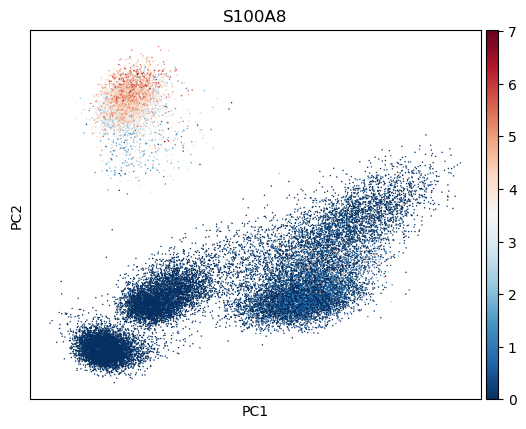

In [21]:
sc.pl.pca(adata_non_immune_hvg,color="S100A8",cmap="RdBu_r")

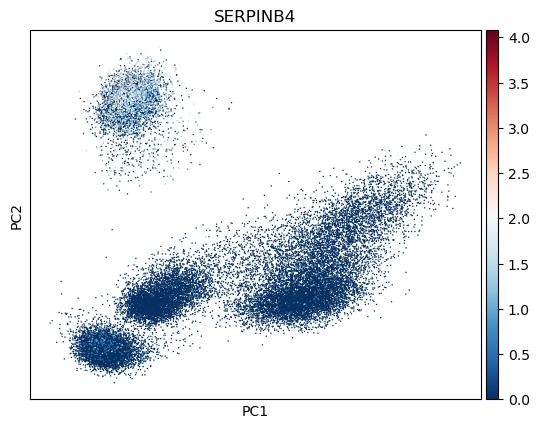

In [22]:
sc.pl.pca(adata_non_immune_hvg,color="SERPINB4",cmap="RdBu_r")

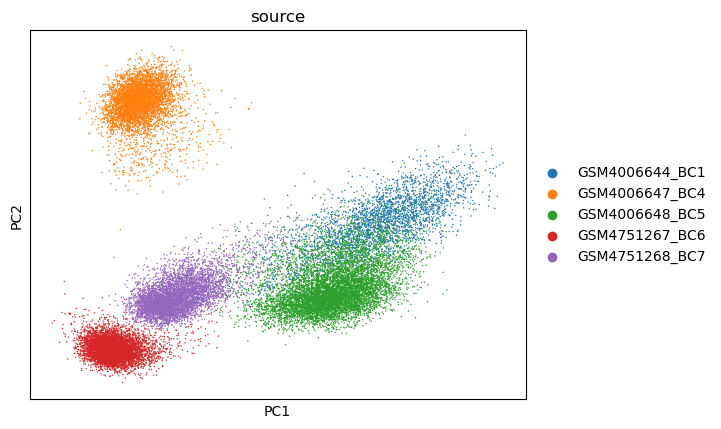

In [23]:
sc.pl.pca(adata_non_immune_hvg,color="source",cmap="RdBu_r")

In [24]:
wkdir= "/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_LINCS/"
data_year = "2020"
cell_name = "BC3C"

data_dir = os.path.join(wkdir,"00_outputs_" + data_year + "_" + cell_name)
data_file = os.path.join(data_dir, "Data_norm_" + data_year + "_" + cell_name+ ".xlsx")
Data_norm = pd.read_excel(data_file, index_col = 0)
display(Data_norm)

genes_list = Data_norm.columns.to_list()
print("Landmark genes in LINCS data:", len(genes_list), genes_list)


,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
ASG002_BC3C_24H:A03,-0.191254,-0.055246,0.039596,-0.256266,-0.040419,-0.590523,-0.159396,-0.074319,0.457981,0.409608,...,0.543203,0.494266,-0.011923,-0.225931,0.285054,-0.775246,0.166031,-0.024873,0.238723,0.284204
ASG002_BC3C_24H:A04,-0.265754,-0.317496,0.118696,-0.136665,-0.301569,-0.403023,0.124804,-0.036470,0.311931,0.660457,...,-0.565096,-0.088634,0.122977,-0.047931,0.141804,0.129054,-0.028819,-0.028773,-0.253627,-0.752646
ASG002_BC3C_24H:A05,-0.181954,-0.081597,-0.210304,1.559535,-0.019019,-0.457423,0.071404,0.074080,-0.356119,0.498808,...,0.226104,-0.228034,-0.121023,-0.075331,-0.133146,0.355054,0.022831,-0.084073,0.283123,-0.894896
ASG002_BC3C_24H:A06,0.033446,0.042404,-0.150154,-0.093165,0.053180,-0.053823,0.087704,0.167681,-0.601569,0.383308,...,-0.608596,-0.228835,0.072777,0.082970,-0.570996,2.847754,-0.211670,-0.067273,0.081723,0.338704
ASG002_BC3C_24H:J13,0.204446,0.180704,0.089096,-0.054666,0.053381,0.044877,-0.277396,-0.157419,0.535681,-3.933493,...,-0.318397,0.122265,-0.134323,-0.088931,-0.067996,-0.515847,-0.005069,0.067527,0.002223,0.204904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MOAR012_BC3C_24H:P20,0.647151,0.211700,-0.979200,0.597350,-0.375751,0.388300,0.394524,0.120151,-0.166775,-1.129125,...,-1.598475,-0.552750,0.515151,0.120800,0.082675,0.529700,0.383225,-0.207225,2.268450,-1.248500
MOAR012_BC3C_24H:P21,0.171800,0.046300,-0.145550,-0.295150,0.030849,0.420951,0.222075,0.179800,0.274724,-0.423975,...,-1.650575,0.203600,-0.003250,-0.064800,-0.037675,0.076499,0.201825,0.416875,0.287450,-0.971700
MOAR012_BC3C_24H:P22,0.648700,0.058749,-0.031700,0.408249,-0.753950,0.332200,-0.357525,-0.107650,-0.213575,0.074225,...,0.127625,0.031600,0.103250,-0.249600,0.046375,1.486200,0.440325,0.090075,-0.031650,-0.944300
MOAR012_BC3C_24H:P23,0.090499,-0.469300,-0.611800,0.873550,-0.788450,-0.097199,-0.366575,-0.490600,-0.624675,-0.009275,...,0.054676,-0.596050,0.084600,0.444700,0.431375,-0.921501,0.044926,0.716076,-0.000900,-1.106700


Landmark genes in LINCS data: 978 ['AARS', 'ABCB6', 'ABCC5', 'ABCF1', 'ABCF3', 'ABHD4', 'ABHD6', 'ABL1', 'ACAA1', 'ACAT2', 'ACBD3', 'ACD', 'ACLY', 'ACOT9', 'ADAM10', 'ADAT1', 'ADGRE5', 'ADGRG1', 'ADH5', 'ADI1', 'ADO', 'ADRB2', 'AGL', 'AKAP8', 'AKAP8L', 'AKR7A2', 'AKT1', 'ALAS1', 'ALDH7A1', 'ALDOA', 'ALDOC', 'AMDHD2', 'ANKRD10', 'ANO10', 'ANXA7', 'APBB2', 'APOE', 'APP', 'APPBP2', 'ARFIP2', 'ARHGAP1', 'ARHGEF12', 'ARHGEF2', 'ARID4B', 'ARID5B', 'ARL4C', 'ARNT2', 'ARPP19', 'ASAH1', 'ASCC3', 'ATF1', 'ATF5', 'ATF6', 'ATG3', 'ATMIN', 'ATP11B', 'ATP1B1', 'ATP2C1', 'ATP6V0B', 'ATP6V1D', 'AURKA', 'AURKB', 'AXIN1', 'B4GAT1', 'BACE2', 'BAD', 'BAG3', 'BAMBI', 'BAX', 'BCL2', 'BCL7B', 'BDH1', 'BECN1', 'BHLHE40', 'BID', 'BIRC2', 'BIRC5', 'BLCAP', 'BLMH', 'BLVRA', 'BMP4', 'BNIP3', 'BNIP3L', 'BPHL', 'BRCA1', 'BTK', 'BUB1B', 'BZW2', 'C2CD2', 'C2CD2L', 'C2CD5', 'C5', 'CAB39', 'CALM3', 'CALU', 'CAMSAP2', 'CANT1', 'CAPN1', 'CARMIL1', 'CASC3', 'CASK', 'CASP10', 'CASP2', 'CASP3', 'CASP7', 'CAST', 'CAT', 'CBLB

In [25]:
adata_non_immune.var.highly_variable.index

Index(['TSPAN6', 'GCLC', 'STPG1', 'CD99', 'HS3ST1', 'TMEM176A', 'CFLAR',
       'TFPI', 'ARF5', 'PLXND1',
       ...
       'CEP83-AS1', 'FO538757.2', 'AC090498.1', 'AC133644.2', 'LINC00921',
       'RP11-2C24.9', 'RP11-422P24.12', 'ADORA3', 'BISPR', 'RP11-297A16.4'],
      dtype='object', name='Gene', length=2500)

In [35]:
genes_list = set(genes_list)
inters= genes_list.intersection(adata_non_immune.var.highly_variable.index)


In [40]:
pd.Series(list(inters)).to_csv(
    '/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/gene_2500_lincs.csv',
    index=False,
    header=False
)

In [27]:
pd.crosstab(adata_non_immune.obs['leiden'], adata_non_immune.obs['source'])

source,GSM4006644_BC1,GSM4006647_BC4,GSM4006648_BC5,GSM4751267_BC6,GSM4751268_BC7
leiden,,,,,
0,67,33,1344,1378,2551
1,214,3887,635,354,175
2,497,33,1464,2215,904
3,751,11,954,118,124
4,227,74,676,726,212
5,423,31,21,548,442
6,43,35,823,423,41
7,204,99,831,72,5
8,297,452,60,76,45


In [28]:
loadings = adata_non_immune_hvg.varm['PCs']  # shape: (n_genes, n_pcs)

# Inspect top genes for PC1, for example
import pandas as pd
pc1 = pd.Series(loadings[:, 0], index=adata_non_immune_hvg.var_names)
top_pc1_genes = pc1.abs().sort_values(ascending=False).head(20)
print(top_pc1_genes)


Gene
CD24      0.082110
RPS18     0.079496
RPS27A    0.078895
RPL27A    0.078203
RPL13A    0.077935
RPS14     0.076175
FTH1      0.075877
RPL11     0.075015
RPL26     0.074569
KRT13     0.073889
CSTB      0.073740
TMEM97    0.072386
IFI27     0.071913
SYT8      0.071677
GSTM3     0.070976
BRI3      0.070448
FTL       0.070237
RPL35A    0.069390
RPL37A    0.069107
RPS4X     0.068964
dtype: float64


In [29]:
pc1

Gene
TSPAN6            0.010245
GCLC              0.021930
STPG1             0.017705
CD99              0.037758
HS3ST1            0.023431
                    ...   
RP11-2C24.9       0.014370
RP11-422P24.12    0.005811
ADORA3            0.000395
BISPR             0.014265
RP11-297A16.4    -0.006475
Length: 2500, dtype: float64

In [30]:
pc2 = pd.Series(loadings[:, 1], index=adata_non_immune_hvg.var_names)

top_pc2_genes = pc2.abs().sort_values(ascending=False).head(20)
print(top_pc2_genes)

Gene
MDM2        0.091925
S100A8      0.091344
DMKN        0.090886
S100A9      0.090851
CDC42SE1    0.090716
S100A14     0.088674
C1orf56     0.088655
CTNNB1      0.088428
SPINK1      0.087337
HNRNPH1     0.086466
EEF1A1      0.083177
RPS24       0.081884
MT1X        0.081853
RPLP0       0.081064
PPP1CB      0.079961
RPS6        0.079069
CDC42       0.078909
RIN2        0.077271
DEFB1       0.075935
PDLIM1      0.074768
dtype: float64


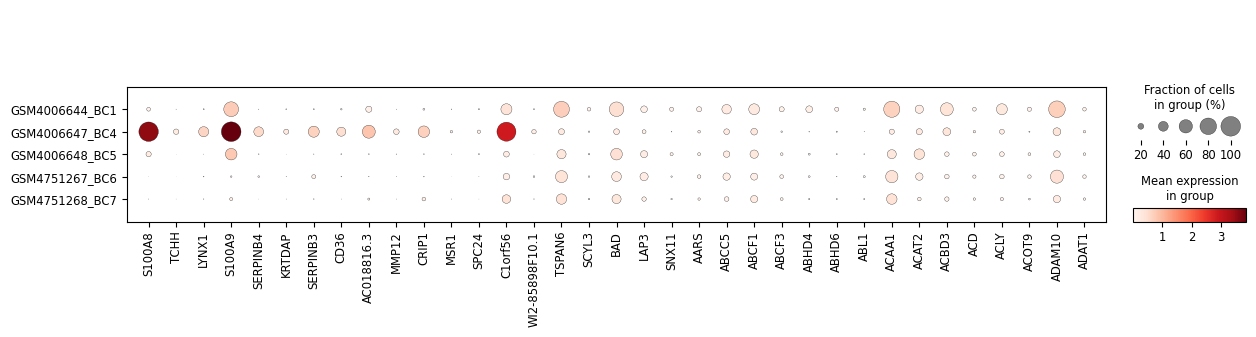

In [31]:
sc.pl.dotplot(adata_non_immune, ["S100A8",
                                 "TCHH",
                                 "LYNX1","S100A9","SERPINB4","KRTDAP","SERPINB3","CD36","AC018816.3","MMP12","CRIP1","MSR1","SPC24","C1orf56","WI2-85898F10.1",
                                 'TSPAN6', 'SCYL3', 'BAD', 'LAP3', 'SNX11','AARS', 'ABCC5', 'ABCF1', 'ABCF3', 'ABHD4', 'ABHD6', 'ABL1', 'ACAA1', 'ACAT2', 'ACBD3', 'ACD', 'ACLY', 'ACOT9', 'ADAM10', 'ADAT1'],groupby='source')#8 umbrella cells

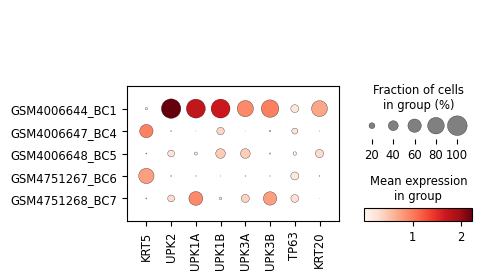

In [33]:
sc.pl.dotplot(adata_non_immune, ['KRT5','UPK2','UPK1A','UPK1B','UPK3A','UPK3B','TP63','KRT20'],groupby='source')#8 umbrella cells